## Canine GWAS Sample QC 

Steps:

- Load target dataset with variants passing QC
    - At this point only an HWE filter will have been applied
- Apply very conservative MAF filter with threshold 0.0001
    - This will have no effect on the target canine dataset since .0001*4342 (samples) < 1
    - As KING is intended to be run with correlated and rare variants, it seems this UKBB step is for nothing other than efficiency (per the KING docs, saving memory is the reason very low MAF filters should be applied)
- Kinship QC
    - The UKBB process for this involves running KING and then fastPCA
    - In Hail, pc_relate can be used to do both as it is in Gnomad
    - Using UKBB thresholds, QC for input to pc_relate will be:
        - Samples
            - Missing rate on autosomes > 0.02.
        - Variants
            - Missing rate > .015
            - MAF < .01
        - Prune with r2 < .1 (windows of 1000 markers and step size of 80 markers)
    - Run pc_relate and analyze related samples 
        - Ensure that there are no incorrect, systematic differences amongst population clusters from variant QC PCA over reference data
    - Remove related samples
- PCA Stage 1
    - Run PCA (on pruned, qc'd sample with no related individuals)
    - Cluster PCA results
    - **Output**: Dataset from Kinship QC with scores and clusters
    
Ensuing notebooks:

- Heterozygosity QC
    - Show HZ by cluster
    - Adjust HZ estimations with linear regression
    - Show adjusted HZ by cluster
    - Run outlier detection and thresholding
    - Remove samples that don't pass 
    - **Output**: Dataset from PCA Stage 1 with fewer samples 
- PCA Stage 2 
    - Run pc_relate to get both kinship estimates and the final PCA scores/loadings
    - Use one-class SVM to choose single representative population?
        - In UKBB [aberrant](https://www.well.ox.ac.uk/~spencer/Aberrant/aberrant-manual.pdf) is used to isolate one large british subset
    
Note that in the second stage of PCA for UKBB:
- This requires identifying SNPs with small loadings in PCA round 1
- Only the SNPs **not** used in population structure are used to infer relatedness
- These SNPs are used for the final kinship estimation
    - This results in a large number of people shifting from 3rd degree relatives (in first round of KING) to unrelated in second round (see Figure S10)
            
            
Things that probably can't be done:

- Remove SNPs in long range LD (e.g. inversions) using known boundaries (Table S13)

In [1]:
import os
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os.path as osp
import functools
from gwas_analysis import nb
from gwas_analysis import pca
from IPython.display import Image
%run {os.environ['NB_DIR']}/nb.py
%run paths.py
%run common.py
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://26f521ec4dc5:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200218-1453-0.2.32-a5876a0a2853.log


In [2]:
def get_target_data():
    mt = hl.read_matrix_table(osp.join(WORK_DIR, TGT_QC_05_FILE + '.mt'))
    ht = hl.read_table(osp.join(WORK_DIR, TGT_QC_04_FILE + '.ht')).key_by('s').drop('index', 'source')
    mtu = mt.annotate_cols(**ht[mt.s])
    assert mt.count() == mtu.count()
    return mtu

mt = get_target_data()
mt.describe()

2020-02-18 14:53:51 Hail: WARN: Name collision: field 'index' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['index']


----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'PC1': float64
    'PC2': float64
    'cluster': int64
----------------------------------------
Row fields:
    'locus': locus<canine>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [3]:
# Show that there is no useful pedigree information
df = mt.select_cols('fam_id', 'pat_id', 'mat_id').cols().to_pandas()
assert df['fam_id'].value_counts().max() == 1
assert df['pat_id'].isnull().all()
assert df['mat_id'].isnull().all()

2020-02-18 14:53:51 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


## QC

In [6]:
%%time

def run_qc(mt):
    print('Original:', mt.count())
    
    mt = mt.filter_rows(mt.locus.in_autosome())
    print('Autosome filtering:', mt.count())
    
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate > .02)
    print('Sample call rate filtering:', mt.count())
    
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate > .015)
    print('Variant call rate filtering:', mt.count())
    
    mt = mt.filter_rows(mt.variant_qc.AF[1] > .01)
    print('Variant MAF filtering:', mt.count())
    
    return mt.drop('variant_qc', 'sample_qc')

mt_qc = run_qc(mt)
mt_qc.write(nb.get_temp_file(WORK_DIR, 'mt_qc.mt'), overwrite=True)

Original: (159562, 4342)
Autosome filtering: (155965, 4342)
Sample call rate filtering: (155965, 4342)
Variant call rate filtering: (155965, 4342)
Variant MAF filtering: (155727, 4342)
CPU times: user 337 ms, sys: 6.84 ms, total: 344 ms
Wall time: 1min 28s


2020-02-18 00:44:54 Hail: INFO: wrote matrix table with 155727 rows and 4342 columns in 6 partitions to /home/eczech/data/gwas/tmp/canine/cg-hail-06/mt_qc.mt


In [5]:
%%time
def run_prune(mt):
    ht = hl.ld_prune(mt.GT, r2=0.1)
    return mt.filter_rows(hl.is_defined(ht[mt.row_key]))
    
mt_pr = run_prune(hl.read_matrix_table(nb.get_temp_file(WORK_DIR, 'mt_qc.mt')))
mt_pr.write(nb.get_temp_file(WORK_DIR, 'mt_pr.mt'), overwrite=True)

2020-02-18 00:38:11 Hail: INFO: ld_prune: running local pruning stage with max queue size of 59075 variants
2020-02-18 00:38:28 Hail: INFO: wrote table with 46597 rows in 6 partitions to file:/tmp/hail.OfAQWKt0gyNP/aTg3H7wAkY
2020-02-18 00:38:54 Hail: INFO: Wrote all 24 blocks of 46597 x 4342 matrix with block size 4096.
2020-02-18 00:42:50 Hail: INFO: wrote table with 10 rows in 23 partitions to file:/tmp/hail.OfAQWKt0gyNP/QCAN7Mv5ph


CPU times: user 3.78 s, sys: 1.45 s, total: 5.22 s
Wall time: 5min 10s


2020-02-18 00:43:17 Hail: INFO: wrote matrix table with 46588 rows and 4342 columns in 6 partitions to /home/eczech/data/gwas/tmp/canine/cg-hail-06/mt_pr.mt


## PCA Round 1 

- Gnomad worfklow involves pc_relate prior to pca (see [here](https://github.com/macarthur-lab/gnomad_qc/blob/afe8effefa0020f0e333caa4e106b0987d98ff07/gnomad_qc/v3/sample_qc/sample_qc.py))

In [30]:
mt_pr = hl.read_matrix_table(nb.get_temp_file(WORK_DIR, 'mt_pr.mt'))
mt_pr = mt_pr.annotate_cols(**mt.cols()[mt_pr.s])
assert mt_pr.aggregate_cols(hl.agg.all(hl.is_defined(mt_pr.cluster)))
mt_pr.count()

(46588, 4342)

In [24]:
%%time
# See: https://github.com/macarthur-lab/gnomad_qc/blob/master/gnomad_qc/v3/sample_qc/sample_qc.py#L424

def run_relation_inference(mt, k=10, min_individual_maf=.01, min_kinship=0.05):
    eig, scores, loadings = hl.hwe_normalized_pca(mt.GT, k=k, compute_loadings=True)
    ht = hl.pc_relate(
        mt.GT, min_individual_maf=min_individual_maf, scores_expr=scores[mt.col_key].scores,
        block_size=4096, min_kinship=min_kinship, statistics='kin'
    )
    return (eig, scores, loadings), ht

pca_data1, ht_relate1 = run_relation_inference(mt_pr)
ht_relate.write(nb.get_temp_file(WORK_DIR, 'ht_relate1.ht'), overwrite=True)
pca_data1[1].write(nb.get_temp_file(WORK_DIR, 'pc_scores1.ht'))
pca_data1[2].write(nb.get_temp_file(WORK_DIR, 'pc_loadings1.ht'))

2020-02-18 01:03:26 Hail: INFO: hwe_normalized_pca: running PCA using 46588 variants.
2020-02-18 01:03:29 Hail: INFO: pca: running PCA with 10 components...
2020-02-18 01:03:41 Hail: INFO: Coerced sorted dataset
2020-02-18 01:03:48 Hail: INFO: Wrote all 24 blocks of 46588 x 4342 matrix with block size 4096.
2020-02-18 01:03:50 Hail: INFO: wrote matrix with 11 rows and 46588 columns as 12 blocks of size 4096 to file:/tmp/hail.OfAQWKt0gyNP/AFApRLug1U.bm
2020-02-18 01:03:50 Hail: INFO: wrote matrix with 46588 rows and 4342 columns as 24 blocks of size 4096 to file:/tmp/hail.OfAQWKt0gyNP/8tUf0EIvcd.bm
2020-02-18 01:03:52 Hail: INFO: wrote matrix with 46588 rows and 4342 columns as 24 blocks of size 4096 to file:/tmp/hail.OfAQWKt0gyNP/79l59X0VOt.bm
2020-02-18 01:13:24 Hail: INFO: wrote matrix with 4342 rows and 4342 columns as 4 blocks of size 4096 to file:/tmp/hail.OfAQWKt0gyNP/Pag79QiolF.bm
2020-02-18 01:22:37 Hail: INFO: wrote matrix with 4342 rows and 4342 columns as 4 blocks of size 40

CPU times: user 1.31 s, sys: 379 ms, total: 1.69 s
Wall time: 59min 34s


2020-02-18 02:02:59 Hail: INFO: wrote table with 71960 rows in 4 partitions to /home/eczech/data/gwas/tmp/canine/cg-hail-06/ht_relate.ht


In [4]:
ht_relate1 = hl.read_table(nb.get_temp_file(WORK_DIR, 'ht_relate1.ht'))
pc_loadings1 = hl.read_table(nb.get_temp_file(WORK_DIR, 'pc_loadings1.ht'))
pc_scores1 = hl.read_table(nb.get_temp_file(WORK_DIR, 'pc_scores1.ht'))

In [70]:
# Note that this is distinct individuals already (it is from the non-diagonal lower triangle)
ht_relate1.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'i': struct {
        s: str
    } 
    'j': struct {
        s: str
    } 
    'kin': float64 
    'ibd0': float64 
    'ibd1': float64 
    'ibd2': float64 
----------------------------------------
Key: ['i', 'j']
----------------------------------------


### Analyze Related Samples

Show the kinship coefficient distribution with our selected threshold.  These results are very different from the UKBB results, which can be seen in figure S11.  [Sams and Boyko 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6325901/) give some intuition for why this may be the case stating that "... humans generally have much lower levels of inbreeding than purebred dogs".  They also go on to use a PI_HAT threshold of .45 when identifying related dogs via PLINK.  We will do the same here:

In [93]:
kc_threshold = .45

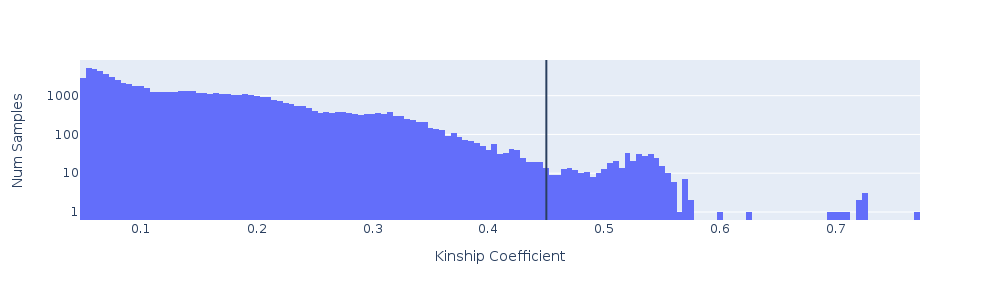

In [87]:
# Compare to figure S11
fig = px.histogram(x=ht_relate1.kin.collect(), log_y=True, nbins=256)
fig.add_shape(dict(
    type="line", xref="x", yref="paper",
    x0=kc_threshold, y0=0, x1=kc_threshold, y1=1
))
fig.update_xaxes(title='Kinship Coefficient')
fig.update_yaxes(title='Num Samples')
Image(fig.to_image('png', width=1000, height=300))

Remove all samples that are in highly related pairs/sets.  

The [Gnomad (v3)](https://macarthurlab.org/2019/10/16/gnomad-v3-0/) approach to this step involves thresholding ```pc_relate``` as above but then tries to retain as many samples as possible by using [maximal_independent_set](https://hail.is/docs/0.2/methods/misc.html?highlight=maximal_independent_set#hail.methods.maximal_independent_set) to  select representative samples from related sets.  We will follow the UKBB approach of simply removing them all though:

In [102]:
def get_filtered_sample_counts(ht):
    ht = ht.annotate(s=[ht.i.s, ht.j.s])
    ht = ht.explode(ht.s)
    ht = ht.group_by(ht.s).aggregate(n=hl.agg.count())
    return ht

ht_rel_ct = get_filtered_sample_counts(ht_relate1.filter(ht_relate1.kin >= kc_threshold))

Show the individuals that will be removed due to having close relatives in the dataset.  

A key observation here is that a clustering of the projected target samples in the PCA space of the reference sample (w/ known breed) makes it possible to determine what breeds these highly related samples correspond to.  Given the severely high degree of relatedness between the first set of samples below, we would expect that this dog breed would be known to have very high levels on consanguinuity.  This is the case since this cluster corresponds to Bull Terriers, a breed previously noted in Dreger et al 2016 ([inbreeding coefficient plots](https://www.instituteofcaninebiology.org/blog/inbreeding-of-purebred-dogs-determined-from-dna)) as being more highly inbred than any other breed next to the Norwegian Lundehund (which is not a breed present in our reference dataset).

The known cluster correspondence is:

- **Cluster 5**: Miniature Bull Terrier (MBLT) and Bull Terrier (BULT)
- **Cluster 2**: Tibetan Spaniel (TIBS) and Afghan Hound (AFGH)
- **Cluster 9**: This one is a mystery -- it is in a region of the reference data PCA space that is very distant from any other samples with a known breed
- **Cluster 1**: These are samples with population structure too heterogeneous to easily isolate (but the fact that most of them only have one or two relatives is a good sign)
- **Cluster -1**: These samples were determined as outliers to all other clusters and have no relationship with one another

2020-02-18 18:55:20 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 18:55:20 Hail: INFO: Coerced sorted dataset


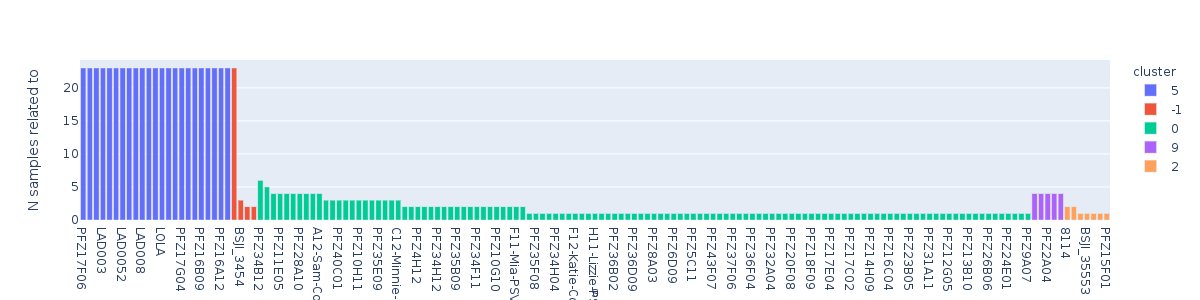

In [137]:
df_rel_ct = (
    ht_rel_ct
    .annotate(cluster=mt.cols()[ht_rel_ct.s].cluster).to_pandas()
    .sort_values('n', ascending=False)
)
fig = px.bar(
    df_rel_ct.assign(cluster=lambda df: df['cluster'].astype(str)), 
    x='s', y='n', color='cluster'
)
fig.update_yaxes(title='N samples related to')
Image(fig.to_image('png', width=1200, height=300))

It is also helpful to see how the number of related samples within a cluster compares to the overall number of samples in the same cluster.  This shows the Bull Terrier samples, the breed expected to have the highest rate of inbreeding, are all (100% of them) highly related to each other.  The much larger heterogeneous cluster contains only 3% related samples which is definitely what we would expect since these samples did not separate well in reference data PCA space  (they would likely have if inbreeding was more prevalent amongst them).

This helps to validate that our selected kinship threshold is isolating samples properly.

In [142]:
pd.concat([
        pd.Series(mt.aggregate_cols(hl.agg.counter(mt.cluster))).rename('n_total'),
        df_rel_ct.groupby('cluster').size().rename('n_related')
    ], 
    axis=1, join='inner'
)\
    .assign(pct_related=lambda df: 100 * df['n_related'] / df['n_total']).round(1)\
    .rename_axis('cluster', axis='index')

,n_total,n_related,pct_related
cluster,,,
0,3843,118,3.1
5,23,23,100.0
9,5,5,100.0
2,17,7,41.2
-1,43,4,9.3


In [146]:
ht_rel_ct.count()

2020-02-18 19:31:31 Hail: INFO: Ordering unsorted dataset with network shuffle


157

In [151]:
mt_pr_ur = mt_pr.filter_cols(~hl.is_defined(ht_rel_ct[mt_pr.s]))
assert mt_pr.count()[1] - ht_rel_ct.count() == mt_pr_ur.count()[1]
mt_pr_ur.count()

2020-02-18 19:32:26 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 19:32:26 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 19:32:27 Hail: INFO: Ordering unsorted dataset with network shuffle


(46588, 4185)

In [152]:
mt_pr_ur.write(nb.get_temp_file(WORK_DIR, 'mt_pr_ur.mt'))

2020-02-18 19:33:18 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 19:33:35 Hail: INFO: wrote matrix table with 46588 rows and 4185 columns in 6 partitions to /home/eczech/data/gwas/tmp/canine/cg-hail-06/mt_pr_ur.mt


### Run PCA

With related samples removed, we can move on to running PCA.  This will then be used to compute PC-adjusted heterozygosity estimations.

In [153]:
mt_pr_ur = hl.read_matrix_table(nb.get_temp_file(WORK_DIR, 'mt_pr_ur.mt'))